In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# for calculating social interactions
import functions.PTWsimulation as ptw
import functions.modelfunctions as mf
 
snscolors=sns.color_palette()

# Run single simulation

### Define parameters and simulation setup

In [6]:
# define parameters
numparticles=10
numsteps = 1 * 10**4


model = mf.simmodel(numparticles,numsteps,)  
model.dt = 0.1
model.savestep=5  # save the results this many steps
model.numsavesteps = np.floor(model.numsimsteps/model.savestep).astype(int) 
model.sigma_speed = 0.2  # this should be sigma_speed/sqrt(tau_speed)

# these should have the length of the number of particles
model.socialweight = np.tile(0.5,numparticles)
model.sigma_turn = 3*np.ones(numparticles)  # note that this should be sigma/sqrt(tau_turn)
model.mu_s = np.ones(numparticles)  # the mean should be 1


# -----

# stop-go added
model.stopgosim=True
# model.Tswitch = np.array([[10,10],[40,10]])
model.stopgosocial = 0.8
# should have dimensions of [N individuals, N_states]
model.statespeedmult = np.array([np.ones(numparticles),0.2/np.array(model.mu_s)]).T  # [individual,states]   # speed multipliers for the states, to modify mu


# simulator can be:  ['ptw','classiczonal','persistantzonal']
whichsim = 'ptw'

# vars(model)

In [7]:
# run simulation
start = time.time()
allparticles = ptw.ptwsimulation(model,showprogress=True,simulator=whichsim)
# get metrices for analyzing results
alldist, alldcoords_rotated = ptw.dist_and_dcoords(allparticles,model)

time.time()-start

8000 10000


17.29390048980713

# Plots of results

the numpy array 'allparticles' contains results stored as:  [timestep, particle, quantity]
The different quantities are:  x, y, vx, vy, spd, ang, angvel, stopgo, state

In [8]:
allparticles.shape

(2000, 10, 9)

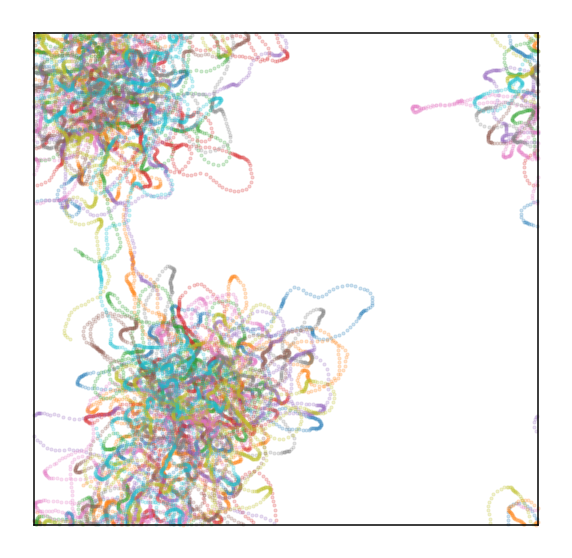

In [9]:
# to make code below easier
numparticles = model.numparticles
xsize, ysize, savestep, dt = model.xsize, model.ysize, model.savestep, model.dt
ind_x, ind_y, ind_vx, ind_vy, ind_spd, ind_ang, ind_angvel, ind_stopgo, ind_state = np.arange(9)
wallsegments=np.array([ [[0,0],[xsize,0]], [[xsize,0],[xsize,ysize]], [[xsize,ysize],[0,ysize]], [[0,ysize],[0,0]] ])
showlen=np.floor(100/savestep).astype(int)

# plot the whole simulated trajectories
f,ax = plt.subplots(1,1)
f.set_size_inches(10,10)
for k in range(len(wallsegments)):
    ax.plot(wallsegments[k,:,0],wallsegments[k,:,1],'k')  
ax.axis('off')
for i in range(numparticles):
    ax.scatter(allparticles[:,i,0],allparticles[:,i,1],color=snscolors[i],alpha=0.2,s=10)

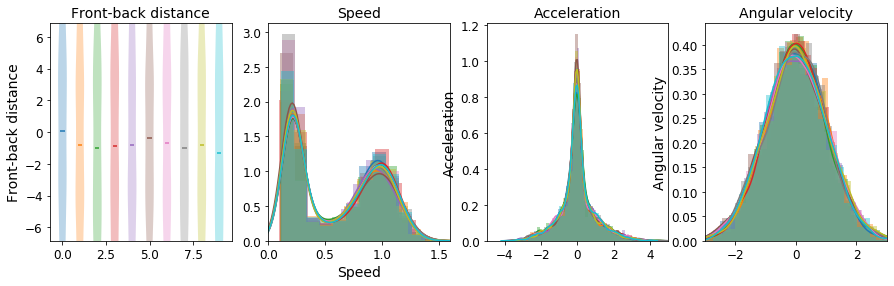

In [10]:
# plots:  front-back dist, speed, ang vel
f, ax = plt.subplots(1,4)
f.set_size_inches(15,4)
# front-back distance
for focus in range(numparticles):
    sel = np.delete(np.arange(numparticles),focus)
    c = alldcoords_rotated[:,focus,sel,0]
    d = alldist[:,focus,sel]
    tp =  - c[d < model.r_attract]  # note the negative sign:  here, plotting which is more of a "leader"
    if len(tp)>0:
        ax[0].violinplot(tp,positions=[focus],showmedians=True,showextrema=False)
    else:
        print('front-back distance:  zero data points')
ax[0].set_ylabel('Front-back distance',fontsize=14)
ax[0].set_title('Front-back distance',fontsize=14)
ax[0].set_ylim([-model.r_align,model.r_align])

# speed
a=ax[1]
[sns.distplot(allparticles[:,focus,ind_spd],ax=ax[1],hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_xlabel('Speed',fontsize=14)
a.set_title('Speed',fontsize=14)
# a.set_ylim([0,2])
a.set_xlim([0,1.6])

# acceleration
a=ax[2]
[sns.distplot(np.gradient(allparticles[:,focus,ind_spd])/dt,ax=a,hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_ylabel('Acceleration',fontsize=14)
a.set_title('Acceleration',fontsize=14)
a.set_xlim([-5,5])

# angvel
a=ax[3]
avmax=10
[sns.distplot(allparticles[:,focus,ind_angvel][np.abs(allparticles[:,focus,ind_angvel])<=avmax],ax=a,hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_xlim([-3,3])
a.set_ylabel('Angular velocity',fontsize=14)
a.set_title('Angular velocity',fontsize=14)

# format
# [a.set_xticks(np.arange(numparticles)) for a in ax]
# [a.set_xlabel('Fish',fontsize=14) for a in ax]
[a.tick_params(labelsize=12) for a in ax]
plt.show()